In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torchvision
from sklearn import metrics
import math
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, random_split

Here we have semantic (or class) segmentation: we paint each front door as dark green, even if we have 5 or just 1 in the image (as opposed to instance segmentation, where we would assign a different color to each front door object/instance).

Useful links & resources:

- https://towardsdatascience.com/efficient-image-segmentation-using-pytorch-part-1-89e8297a0923
- https://www.tensorflow.org/tutorials/images/segmentation
- https://github.com/sheikhazhanmohammed/sadma
- https://www.kaggle.com/code/yassinealouini/all-the-segmentation-metrics
- https://github.com/milesial/Pytorch-UNet
- https://github.com/asanakoy/kaggle_carvana_segmentation/tree/master

Pretrained models:

- https://pytorch.org/serve/model_zoo.html
- https://pytorch.org/vision/stable/models.html#object-detection-instance-segmentation-and-person-keypoint-detection

In [31]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv_block(x)


class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            ConvBlock(in_channels, out_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # output shape excluding channels (same for both height and width) is:
        # out = (in - 1) * stride - 2 * padding + (kernel_size - 1) + 1
        # here, with padding = 0, we get:
        # out = (stride * in) - (2 * stride) + kernel
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1) # x1 and x2 need to have the same number of rows, I think
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1) # maybe wrap this in a sigmoid?

    def forward(self, x):
        return self.conv(x)



class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        self.inc = (ConvBlock(3, 64, 64)) 
        self.down1 = (Down(64, 128)) 
        self.down2 = (Down(128, 256)) 
        self.down3 = (Down(256, 512)) 
        self.down4 = (Down(512, 1024)) 
        self.up1 = (Up(1024, 512)) 
        self.up2 = (Up(512, 256))
        self.up3 = (Up(256, 128))
        self.up4 = (Up(128, 64))
        self.outc = (OutConv(64, 1))

    def forward(self, x):
        x1 = self.inc(x) # x1 HxW: 256x256
        x2 = self.down1(x1) # x2 HxW: 128x128
        x3 = self.down2(x2) # x3 HxW: 64x64
        x4 = self.down3(x3) # x4 HxW: 32x32
        x5 = self.down4(x4) # x5 HxW: 16x16
        x = self.up1(x5, x4) # up(x5) gives 32x32, concat with x4, HxW remains 32x32 and the channels are added
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x2, x1) # x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


def accuracy(outputs, targets):
    # Assuming binary segmentation
    preds = torch.sigmoid(outputs)
    preds = (preds > 0.5).float()  # Convert to binary predictions
    correct = (preds == targets).sum().item()
    total = targets.numel()
    acc = correct / total
    return acc
def save_model(model, optimizer, epoch, loss, accuracy, save_path):
    state = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss,
        'accuracy': accuracy
    }
    torch.save(state, save_path)
    print(f'Model saved at {save_path}')

def load_model(model, optimizer, load_path):
    checkpoint = torch.load(load_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    loss = checkpoint['loss']
    accuracy = checkpoint['accuracy']
    print(f'Model loaded from {load_path}')
    return model, optimizer, epoch, loss, accuracy

def train_model(model, epochs, batch_size, optimizer, loss_fn,save_path=None,scheduler=None,):
    if not torch.cuda.is_available():
        print("CUDA NOT AVAILABLE!!!!")
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    train_steps = len(train_loader)
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    for epoch in range(1, epochs + 1):
        epoch_loss = 0
        epoch_acc = 0
        model.train()
        train_loader_enum = enumerate(train_loader, 1)
        for step, (inputs, masks) in train_loader_enum:  # Start counting steps from 1
            print(f"Epoch: {epoch}, step: {step} out of {train_steps}.")
            inputs, masks = inputs.to(device), masks.to(device)
            optimizer.zero_grad()
            output = model(inputs.to(device))
            
            batch_loss = loss_fn(output.squeeze(), masks)
            batch_loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()
            epoch_loss += batch_loss.item()
            
            batch_acc = accuracy(output, masks)
            epoch_acc += batch_acc
        
        epoch_acc /= train_steps
        train_accuracies.append(epoch_acc)
        train_losses.append(epoch_loss / batch_size)
        
        train_preds, train_targs = [], []
        with torch.no_grad():
            model.eval()
            val_loss = 0
            val_acc = 0
            for inputs, masks in val_loader:
                output = model(inputs.to(device))
                val_loss += loss_fn(output.squeeze(), masks.to(device)).item()
                
                batch_acc = accuracy(output.squeeze(), masks.to(device))
                val_acc += batch_acc
            
            val_acc /= len(val_loader)
            val_accuracies.append(val_acc)
            val_losses.append(val_loss / batch_size)
        
        if save_path is not None:
            save_model(model, optimizer, epoch, epoch_loss, epoch_acc, save_path)
        print(f"Epoch train loss: {train_losses[-1]}, train accuracy: {train_accuracies[-1]}")
        print(f"Epoch validation loss: {val_losses[-1]}, validation accuracy: {val_accuracies[-1]}")

Model loaded from model.pth


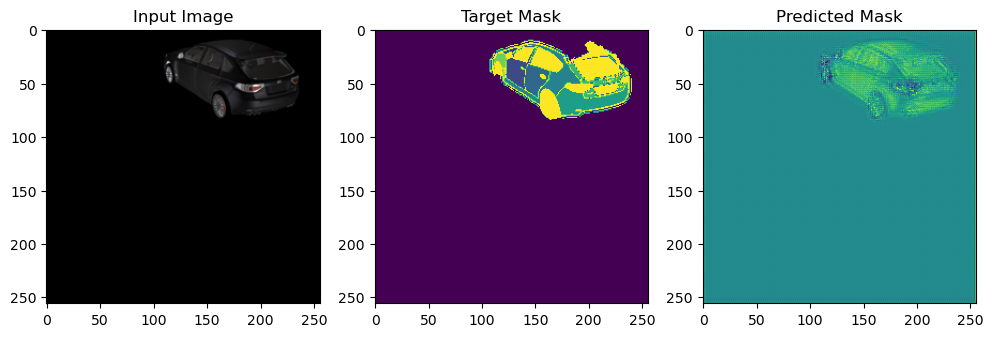

In [36]:


# Load the trained model
loaded_model = UNet()
loaded_optimizer = optim.Adam(loaded_model.parameters(), lr=1e-5, weight_decay=1e-4)
load_path = 'model.pth'
loaded_model, loaded_optimizer, _, _, _ = load_model(loaded_model, loaded_optimizer, load_path)

# Choose an example from the test set
example_index = 12
example_input, example_target = test_set[example_index]
example_input = example_input.unsqueeze(0)  # Add a batch dimension

# Move the input to the appropriate device (CPU or GPU)
example_input = example_input.to(device)

# Set the model to evaluation mode
loaded_model.eval()

# Make a prediction
with torch.no_grad():
    prediction = loaded_model(example_input)

# Post-process the prediction if needed (e.g., convert to probabilities)
predicted_mask = torch.sigmoid(prediction.squeeze())

# Visualize the input, target, and predicted mask
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(example_input.squeeze().permute(1, 2, 0).cpu().numpy())
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(example_target.cpu().numpy())
plt.title('Target Mask')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask.cpu().numpy())
plt.title('Predicted Mask')

plt.show()


In [ ]:
# model.save('trained_model.h5')

In [ ]:
# Run the output on the test set

In [ ]:
# Try pretrained models: MobileNetV2, ResNet101